# Churn Prediction (IBM Analytics Communities)

## Interpretation

The goal of this challenge is three-fold:

1. Find out the most predictive indicators that lead to a customer 'churning' or leaving the company. Find the underlying variables that lead to this prediction.

2. Create a model that can predict with high accuracy whether a customer is likely to churn or not.

3. Suggest improvements to the company that will help them increase customer retention.



---

## Imports (Setup)

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns


from sklearn.model_selection import cross_val_score,\
            StratifiedKFold, GridSearchCV, train_test_split,\
            learning_curve, ShuffleSplit
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import preprocessing

from sklearn.linear_model import LogisticRegressionCV,\
            LogisticRegression, SGDClassifier

from sklearn.metrics import confusion_matrix, accuracy_score,\
                            roc_curve, auc, precision_recall_fscore_support

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier,\
                             AdaBoostClassifier, RandomTreesEmbedding

from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC


from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils import to_categorical
from keras.models import load_model
from keras.utils import plot_model


pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)

# create a data-frame and output first 5 rows
df = pd.read_csv('./churn-prediction.csv')
df.head(5)

Using TensorFlow backend.


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


---

## Explanatory Analysis (Visualizations & Statistics)


#### Finding Empty or Nan Entries 


In [3]:
df.info()
for colName in df.columns.values:
  #print("\nCol: ", colName)
  print()
  print(df[colName].describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

We note that total charges are considered as an object type, this may mean that a problem in the data-set has disallowed it to be of float64 type. We will try to convert this to numeric, convert all non-numbers to nan and then try to find any such values.

Col_19 i.e. totalCharges has some NaN values as it was probably empty, we will simply remove these records as they are only 11 out of 7043 so they only represent 0.0016% of the entire data-set.

#### Variable Types and Target Variable Distribution

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7032 non-null object
gender              7032 non-null object
SeniorCitizen       7032 non-null int64
Partner             7032 non-null object
Dependents          7032 non-null object
tenure              7032 non-null int64
PhoneService        7032 non-null object
MultipleLines       7032 non-null object
InternetService     7032 non-null object
OnlineSecurity      7032 non-null object
OnlineBackup        7032 non-null object
DeviceProtection    7032 non-null object
TechSupport         7032 non-null object
StreamingTV         7032 non-null object
StreamingMovies     7032 non-null object
Contract            7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
Churn               7032 non-null object
dtypes: float64(2), int64(2), ob

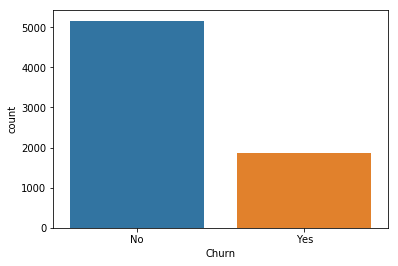

In [4]:
df['TotalCharges'] = df['TotalCharges'].apply(pd.to_numeric, errors='coerce')

np.where(df.isnull())

df = df[pd.notnull(df['TotalCharges'])]
df.info()

## target variable class distribution
sns.countplot(df.Churn)

### Demographic Variable Analysis

In this analysis we explore the demographic related variables.

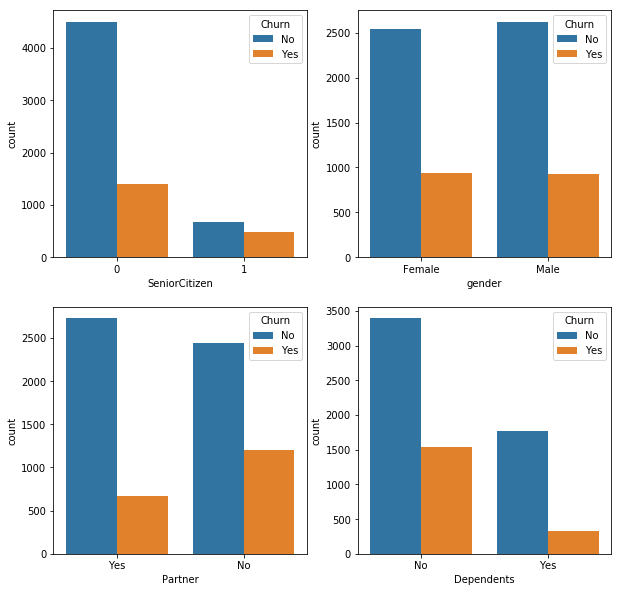

In [342]:
### explore demo-graphic variables...

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

sns.countplot(df.SeniorCitizen, hue=df.Churn, ax=axes[0,0])
sns.countplot(df.gender, hue=df.Churn, ax=axes[0,1])
sns.countplot(df.Partner, hue=df.Churn, ax=axes[1,0])
sns.countplot(df.Dependents, hue=df.Churn, ax=axes[1,1])

#plt.figure(figsize = (4,4))
#sns.countplot(df.PhoneService, hue=df.Churn)


#### Findings
Looking at the demographic variables:

- Although senior citizens represent a much smaller proportion of customers, they are more likely to churn than non-senior customers.
- The probability of churn is unaffected by gender.
- The chances of churning almost doubles if the customer does not have a partner and this is even more clearer when they are no dependents.

#### Suggestions
The company should focus their advertising and marketing towards senior citizens and especially towards single and non-dependent customers.



### Product Analysis

In this analysis we will look at the different services chosen by the customers and try to identify any patterns that may lead to churn. 

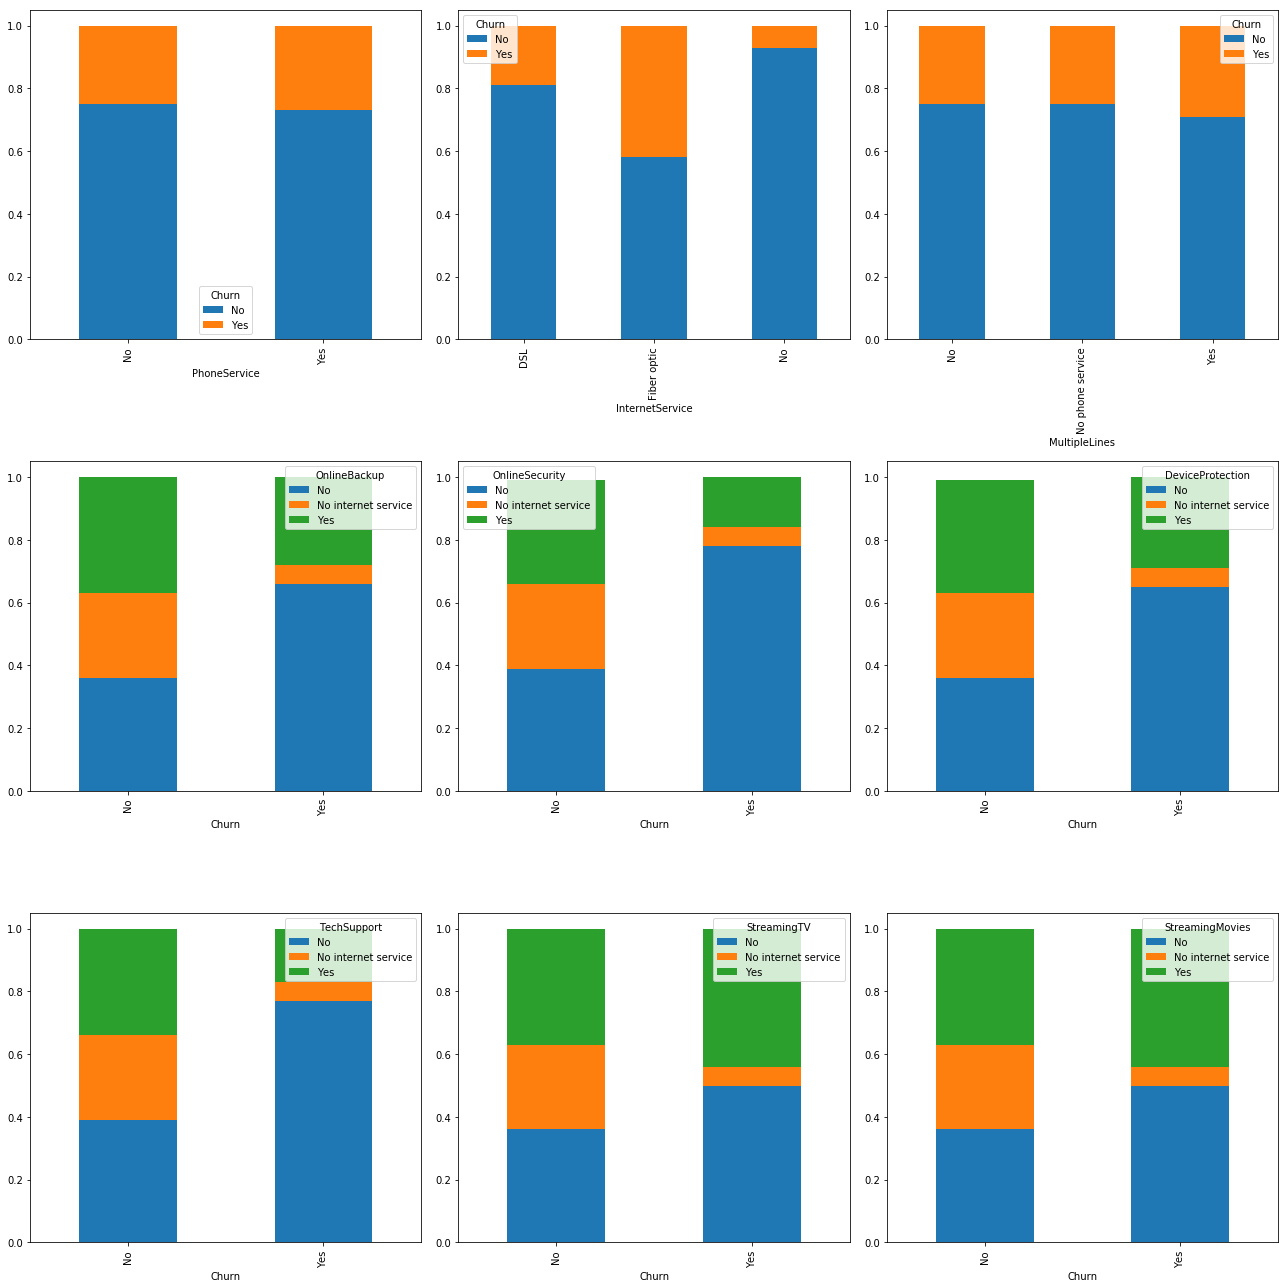

In [343]:
#sns.set(style='whitegrid')

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18,18))
#df2.head(5)

#plt.figure(figsize = (2,2))
pd.crosstab(df['PhoneService'],df['Churn'])\
.apply(lambda r: np.round(r/r.sum(),2), axis=1).plot.bar(stacked=True, ax=axes[0,0])

#plt.figure(figsize = (2,2))
pd.crosstab(df['InternetService'],df['Churn'])\
.apply(lambda r: np.round(r/r.sum(),2), axis=1).plot.bar(stacked=True, ax=axes[0,1])


#plt.figure(figsize = (2,2))
pd.crosstab(df['MultipleLines'],df['Churn'])\
.apply(lambda r: np.round(r/r.sum(),2), axis=1).plot.bar(stacked=True,  ax=axes[0,2])

pd.crosstab(df['Churn'],df['OnlineBackup'])\
.apply(lambda r: np.round(r/r.sum(),2), axis=1).plot.bar(stacked=True,  ax=axes[1,0])

pd.crosstab(df['Churn'], df['OnlineSecurity'])\
.apply(lambda r: np.round(r/r.sum(),2), axis=1).plot.bar(stacked=True,  ax=axes[1,1])

pd.crosstab(df['Churn'], df['DeviceProtection'])\
.apply(lambda r: np.round(r/r.sum(),2), axis=1).plot.bar(stacked=True,  ax=axes[1,2])
pd.crosstab(df['Churn'], df['TechSupport'])\
.apply(lambda r: np.round(r/r.sum(),2), axis=1).plot.bar(stacked=True,  ax=axes[2,0])

pd.crosstab(df['Churn'], df['StreamingTV'])\
.apply(lambda r: np.round(r/r.sum(),2), axis=1).plot.bar(stacked=True,  ax=axes[2,1])
pd.crosstab(df['Churn'], df['StreamingMovies'])\
.apply(lambda r: np.round(r/r.sum(),2), axis=1).plot.bar(stacked=True,  ax=axes[2,2])

plt.tight_layout()


#### Findings/Predictions:

- Customers seem to be unhappy with the fibre-optic service as customers with a Fibre optic connection are twice as likely to churn than those with a DSL connection.
- Generally, customers who churn are highly likely not to buy additional premium services. 
- The only two exceptions to the above statement are the streaming movie and tv services which are almost equally likely to be chosen by churn/non-churn customers. Thus these are not a good predictors for churn.


#### Suggestions:
- The cause of Churning due to Fibre optics should be further investigated with competitor analysis as well as feedback from those who left to gain insights on short-comings.
- The streaming service department seems to be doing a good job.
- Not buying additional premium services could possibly be an early indicator to predict whether a customer will churn. This can be be later correlated with total monthly charges.

### Billing Scheme Analysis

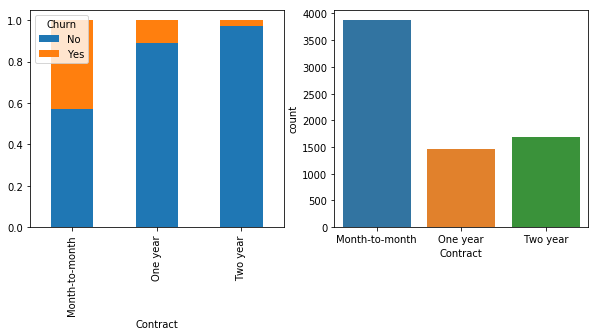

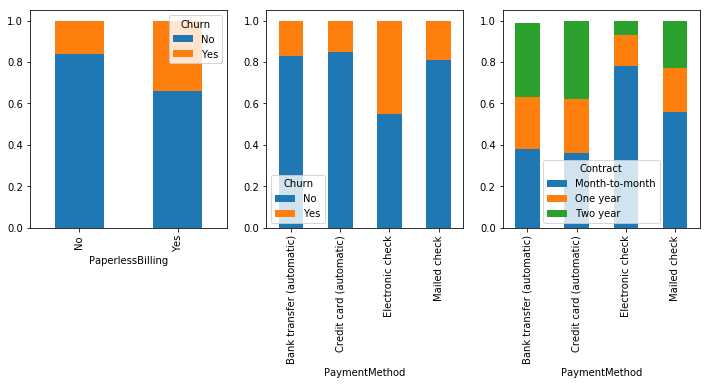

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
fig2, axes2 = plt.subplots(nrows=1, ncols=3, figsize=(12,4))


pd.crosstab(df['Contract'], df['Churn'])\
.apply(lambda r: np.round(r/r.sum(),2), axis=1).plot.bar(stacked=True, ax=axes[0])

#### plot showing monthly vs one-year vs two-year count
#plt.figure(figsize = (3.5,3.5))
sns.countplot(df.Contract, ax=axes[1])

# contract, paperlessbilling, payment method
pd.crosstab(df['PaperlessBilling'], df['Churn'])\
.apply(lambda r: np.round(r/r.sum(),2), axis=1).plot.bar(stacked=True,  ax=axes2[0])
pd.crosstab(df['PaymentMethod'],df['Churn'])\
.apply(lambda r: np.round(r/r.sum(),2), axis=1).plot.bar(stacked=True,  ax=axes2[1])

pd.crosstab(df['PaymentMethod'],df['Contract'])\
.apply(lambda r: np.round(r/r.sum(),2), axis=1).plot.bar(stacked=True,  ax=axes2[2])


#g = sns.PairGrid(df, vars=["tenure", "MonthlyCharges", "TotalCharges"], hue="Churn")
#g.map(plt.scatter)



#### Findings:
- Churn probablity significantly reduces for longer term contracts (1-2 years) as compared to monthly contracts. This makes sense as customers with short-term contracts can easily leave the company within a month's time. This insight will be further anlysed when we look at tenure vs churn.
- Those with paperless-billing are almost twice as likely to churn than those who are paper billed.
- People with electronic check as a payment method are most likely to churn compared to all other payment methods with a rough 50% probability of churn with this payment method.
- Further analysis shows that this type of method is very popular with customers opting for monthly payments. This shows that having a monthly payment scheme with an electronic check as an option could be a strong indicator for churn.

#### Suggestions:
- The company should introduce discount and promotional schemes to persuade exisiting and newer customers to take up longer contracts, this can improve customer retention rates.


### Continuous Data Analysis

We now investigate the cause/effect and trends for all the real numbered quantities present in this dataset.

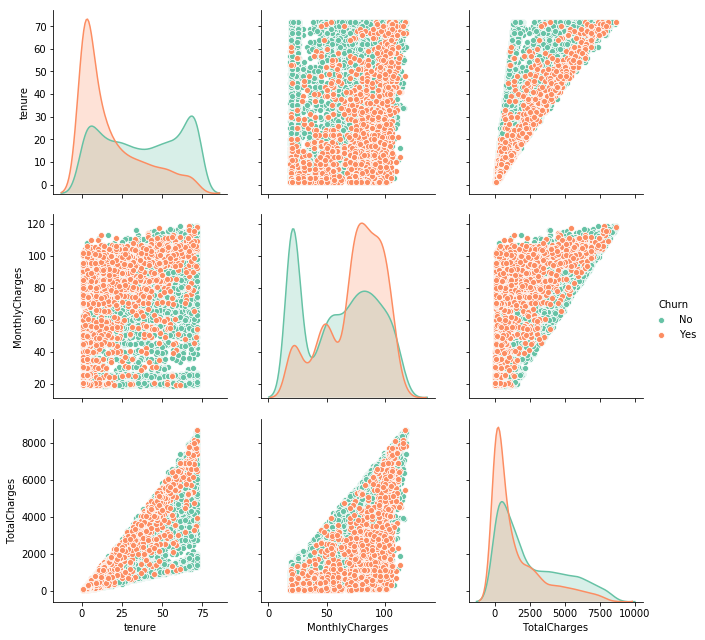

In [12]:
## Plot a scatter plot for all numeric variables and histogram to show their frequency.
## Need seaborn version 0.9.0
g = sns.pairplot(df, vars=["tenure", "MonthlyCharges", "TotalCharges"],\
                 palette="Set2", hue='Churn', diag_kind="kde", height=3)

#gf = sns.FacetGrid(df, hue="Churn")
#gf = gf.map(sns.kdeplot, "tenure")



The plots on the diagonal are approximate PDF of each variable while the other plots show the trend or general relationship between the respective variables.

Here we notice that those who churned have higher monthly charges. However, it was observed earlier that very few of the churned customers actually opted for additional services. We will investigate this further.


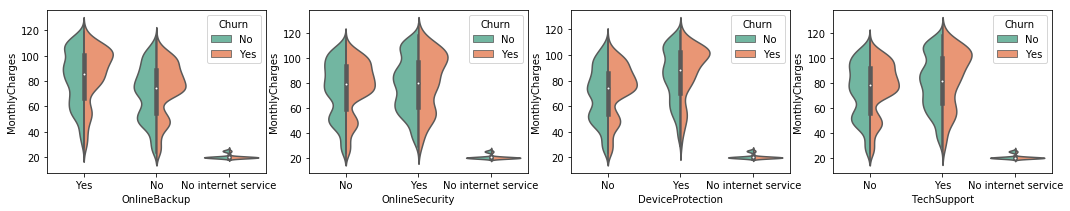

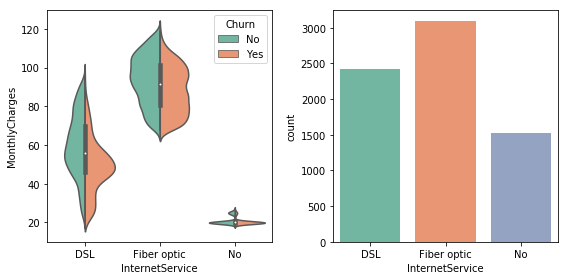

In [347]:
_,axes = plt.subplots(nrows=1, ncols=4, figsize=(18,3))

sns.violinplot(x="OnlineBackup", y="MonthlyCharges",\
                 hue="Churn", split=True,\
                 palette="Set2", data=df, ax=axes[0])
sns.violinplot(x="OnlineSecurity", y="MonthlyCharges",\
                 hue="Churn", split=True,
                 palette="Set2", data=df, ax=axes[1])
sns.violinplot(x="DeviceProtection", y="MonthlyCharges",\
                 hue="Churn", split=True,
                 palette="Set2", data=df, ax=axes[2])
sns.violinplot(x="TechSupport", y="MonthlyCharges",\
                 hue="Churn", split=True,
                 palette="Set2", data=df, ax=axes[3])


### plot on newer fig with 'catplot'
_,axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
sns.violinplot(x="InternetService", y="MonthlyCharges",\
                 hue="Churn", kind="violin", split=True,
                 palette="Set2", data=df, ax=axes[0])
sns.countplot(x="InternetService", palette="Set2", data=df, ax=axes[1])
#plt.figure(figsize = (4,4))
#sns.countplot(x="InternetService", data=df)

plt.tight_layout()

#### Findings

- Monthly rates of churned customers generally tend to be higher, this is related with an earlier observation that most churned customers have a fibre optic connection which by itself is one of the key reasons behind an increased monthly rate. Notice how premimum services span the entire monthly rate range while fibre optic is only at the high end.

- A significant proportion of customers who churn have a very low tenure (about 1-2 months). This is in-line with an earlier observation that most customers who churned had a monthly contract.

- As tenure increases, there is a considerable drop in churn-rates between 0-24 months. This is in-line with an earlier observation that people bound with long term contracts (and hence are obliged to stay) tend to remain loyal for a longer period of time even after their initial contracts have ended.

- A majority of total charges peak around the lower range (0-2500) for both churn and non-churn customers. While churn customers tend to leave early, the reason for low totals from loyal customers is because most of them have low monthly charges.

- As expected, there is a positive correlation between total charges vs monthly charges and total charges vs tenure. However, there is a large spread in this relation (near the higher end) which could be due to changes in monthly charges in the past.



#### Suggestions
- The need to improve the fibre optic service is further backed by the monthly rates of churned customers. This is a much sought after service and improving it should not only improve customer retention but also overall total charges in future.

- Older customers can be persuaded to take up additional services to improve revenue in the long term.


---

## Data Wrangling (Assumptions)

Before we feed the data to classifiers we must tweak it appropriately to make it 'machine-friendly'. In general we will use boolean (0 or 1) values wherever possible and remove any features that seem to have no affect on churn from earlier analysis. Using boolean features are easier for models to learn than categorical variables and they also scale nicely. It is often found that one-hot encoding improves accuracy when using a wide variety of models.


#### Field Analysis
- CustomerID will be removed as it is irrelevant for prediction.
- PhoneServices and Gender columns will also be removed as their ratios are almost the same between churn and no churn.
- All 'no-phone-service' options will be changed to 'no' as this is a still valid assumption (i.e. intuitively it makes sense) and it also makes the variable a boolean type. The no-phone service info is unlikely to affect churn/no-churn.
- All 'no-internet-service' options will be changed to 'no' as this is still valid assumption and the original information still exists in another column.
- All yes/no options will be converted to 0/1 and all categorical variables to dummy vars for one-hot encoding.



In [5]:
df2 = df.drop(['customerID','gender','PhoneService'], axis=1)

## for mult-line col: 3 opt -> 2 opt
df2 = df2.replace({'No phone service': 'No'})
df2 = pd.get_dummies(df2, columns=['SeniorCitizen', 'Partner', 'Dependents',\
                                   'PaperlessBilling', 'MultipleLines', 'Churn'],\
                     drop_first=True)
df2 = pd.get_dummies(df2, columns=['InternetService', 'Contract', 'PaymentMethod'])

## for extra internet services, already present 'no int serv' -> now just say 'no' 
df2 = df2.replace({'No internet service': 'No'})
df2 = pd.get_dummies(df2, columns=['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',\
                                   'TechSupport', 'StreamingTV', 'StreamingMovies'],\
                     drop_first=True)

df2 = df2.reindex(columns=(list([a for a in df2.columns if a != 'Churn_Yes']\
                                + ['Churn_Yes']) ))

df2.info()
df2.describe()

#sns.countplot(df2['InternetService_DSL'], hue=df2.Churn_Yes)

# 3 (dropped) + 2 (new dummy for IntServ) + 2(new dummy for Contr) + 3 (new dummy for PayMeth)
assert(df2.shape[1] == df.shape[1] - 3 + 2 + 2 + 3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 25 columns):
tenure                                     7032 non-null int64
MonthlyCharges                             7032 non-null float64
TotalCharges                               7032 non-null float64
SeniorCitizen_1                            7032 non-null uint8
Partner_Yes                                7032 non-null uint8
Dependents_Yes                             7032 non-null uint8
PaperlessBilling_Yes                       7032 non-null uint8
MultipleLines_Yes                          7032 non-null uint8
InternetService_DSL                        7032 non-null uint8
InternetService_Fiber optic                7032 non-null uint8
InternetService_No                         7032 non-null uint8
Contract_Month-to-month                    7032 non-null uint8
Contract_One year                          7032 non-null uint8
Contract_Two year                          7032 non-null uint8
Payment

---

## Prediction (Model Selection & Validation)

### Pre-training
- Convert to np array for computations
- split into (train+cv):test set with 75:25 ratio
- All training will be done using cross-validation. Thus hyper params will be selected  based on Cross Val. 10-fold (standard) splits will be used where possible but reduced to 3 when there are too many hyper-parameters to try out.
- Final testing will be done based on 25% of the data-set.
- There is an imbalance of churn vs no-churn in the dataset, it is essential that this distribution is maintained in the train and test sets. This is done using the 'stratified' option when splitting data.


In [6]:
#### Helper Function

    
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


def plot_roc(clf, yTest, XTest, title=''):
    fpr, tpr, _ = roc_curve(yTest, clf.predict_proba(XTest)[:,1])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.title(title)
    return plt

In [7]:
# fixed for reproducable results
randState = 193
splitRatio = 0.75

# get np array
npDatArray = df2.values
#print("Array:\n", npDatArray)

X_all = npDatArray[:, :-1]
y_all = npDatArray[:, -1].astype(int)

stratifier = y_all
X_train, X_test, y_train, y_test = \
    train_test_split(X_all, y_all,\
                test_size=(1-splitRatio), shuffle=True,\
                stratify=stratifier, random_state=randState)

ten_fold_cv = StratifiedKFold(n_splits=10,\
                                shuffle=True, random_state=randState)



##### Feature Scaling
- Performed only as a pre-processor, learnt parameters from training set is used on test/cross-val set to avoid data-snooping.
- Normalisation Option: convert all features to zero mean and unit variance. Boolean features are largely unaffected as they still will be 2 unique values but now on a similar scale as other variables.

### Simple Base-Line Logistic Regression

Mean CV Accuracy: 80.45% (+/- 1.09%)
*** Test-set accuracy: 80.03% ***

Precision: 0.65;	Recall: 0.54;		F1-Score: 0.59;



<module 'matplotlib.pyplot'>

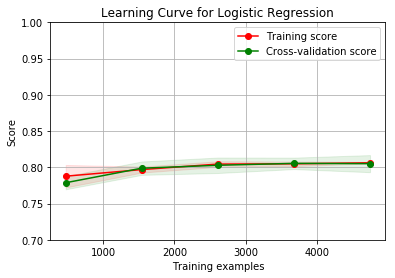

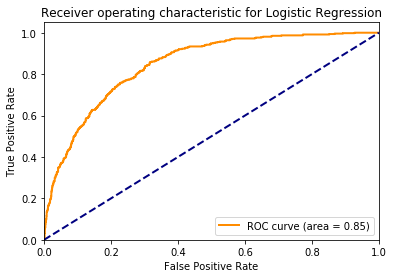

In [359]:
### simple baseline logistic regression, no tuning

clf = make_pipeline(preprocessing.StandardScaler(),\
                    SGDClassifier(loss="log", penalty=None, max_iter=1000,\
                                  random_state=randState))
scores = cross_val_score(clf, X_train, y_train,cv=ten_fold_cv)
print("Mean CV Accuracy: %.2f%% (+/- %.2f%%)" % (scores.mean()*100, scores.std()*100))

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("*** Test-set accuracy: %0.2f%% ***" % (accuracy_score(y_test, y_pred)*100))

#print(classification_report(y_test, y_pred, labels=['Churn']))
precision, recall, f1_score, _ = \
    precision_recall_fscore_support(y_test, y_pred, average='binary')
    

print("\nPrecision: %0.2f;\tRecall: %0.2f;\t\tF1-Score: %0.2f;\n"\
      % (precision, recall, f1_score))

## plot learning curve to investigate further
plot_learning_curve(clf, "Learning Curve for Logistic Regression", X_train, y_train,\
                    cv=ten_fold_cv, n_jobs=4, ylim=(0.7,1))

plot_roc(clf, y_test, X_test,\
         title='Receiver operating characteristic for Logistic Regression')


### Tuned Gradient Boost Classifier

In [8]:
### gridSearch for best classifier params
pipe = Pipeline([
        ('std', preprocessing.StandardScaler()),
        ('gbc', GradientBoostingClassifier(random_state=randState))  # ExtraTreesClassifier())
    ])

### the grid was narrowed after subsequent searches
param_grid = [{
                'gbc__n_estimators': [85, 90, 100],
                'gbc__learning_rate': [0.1, 0.095, 0.09],
                'gbc__min_samples_leaf': [10, 11, 12],
                'gbc__min_samples_split': [2, 3, 5],
                'gbc__max_features': [1]
              }]


model_tuner = GridSearchCV(pipe, param_grid, cv=3,\
                           n_jobs=-1, verbose=1, return_train_score=True)
model_tuner.fit(X_train, y_train)
print()

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:   23.7s finished



Best parameters set found on development set:
{'gbc__learning_rate': 0.1, 'gbc__max_features': 1, 'gbc__min_samples_leaf': 12, 'gbc__min_samples_split': 2, 'gbc__n_estimators': 100}


Now training with entire train-set with best params...

*** Best GradBoost 10f-CV accuracy: 80.55% (+/- 0.90%) ***
*** Best GradBoost Test-set accuracy: 80.38% ***

Precision: 0.67;	Recall: 0.52;		F1-Score: 0.59;



<module 'matplotlib.pyplot' from 'C:\\Users\\Haaris\\AppData\\Roaming\\Miniconda3\\envs\\ml\\lib\\site-packages\\matplotlib\\pyplot.py'>

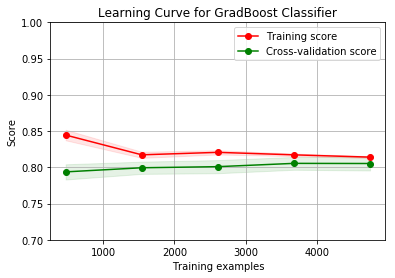

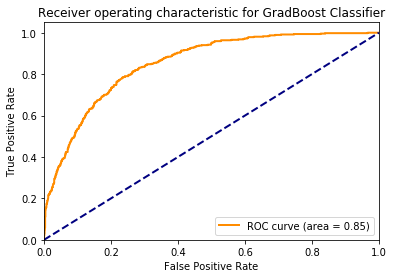

In [9]:
means = model_tuner.cv_results_['mean_test_score']
stds = model_tuner.cv_results_['std_test_score']
print("\nBest parameters set found on development set:")
print(model_tuner.best_params_)
print()


print("\nNow training with entire train-set with best params...\n")
bestPipe = Pipeline([
        ('std', preprocessing.StandardScaler()),
        ('gbc',\
         GradientBoostingClassifier(\
                        n_estimators=model_tuner.best_params_['gbc__n_estimators'],
                        learning_rate=model_tuner.best_params_['gbc__learning_rate'],
                        min_samples_leaf=model_tuner.best_params_['gbc__min_samples_leaf'],
                        min_samples_split=model_tuner.best_params_['gbc__min_samples_split'],
                        max_features=model_tuner.best_params_['gbc__max_features'],
                        random_state=randState))
    ])
scores = cross_val_score(bestPipe, X_train, y_train,cv=ten_fold_cv)
print("*** Best GradBoost 10f-CV accuracy: %.2f%% (+/- %.2f%%) ***" %\
      (scores.mean()*100, scores.std()*100))

bestPipe.fit(X_train, y_train)
y_pred = bestPipe.predict(X_test)
print("*** Best GradBoost Test-set accuracy: %0.2f%% ***" %\
      (accuracy_score(y_test, y_pred)*100))

precision, recall, f1_score, _ = \
    precision_recall_fscore_support(y_test, y_pred, average='binary')


print("\nPrecision: %0.2f;\tRecall: %0.2f;\t\tF1-Score: %0.2f;\n"\
      % (precision, recall, f1_score))

## plot learning curve to investigate further
plot_learning_curve(bestPipe, "Learning Curve for GradBoost Classifier", X_train, y_train,\
                    cv=ten_fold_cv, n_jobs=4, ylim=(0.7,1))

plot_roc(bestPipe, y_test, X_test,\
         title='Receiver operating characteristic for GradBoost Classifier')


#### Feature importance (from Gradient Boost)

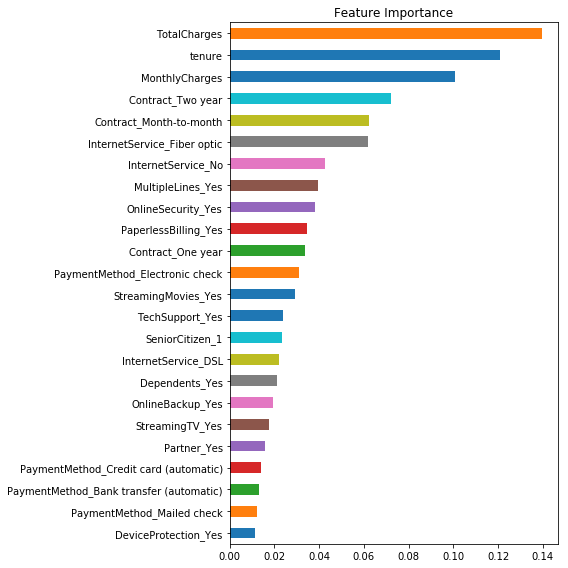

In [336]:
### plot feature importance


plt.figure(figsize = (8,8))
pd.Series(bestPipe.named_steps['gbc'].feature_importances_,\
                      index=df2.columns.values[:-1])\
                    .sort_values().plot(kind='barh', title="Feature Importance")
plt.tight_layout()

### Prediction Analysis
#### Accuracy

- Most classifier models tested predicted churn/no-churn with upto 79-80% accuracy.
- The best test-set accuracy was found with the gradient boost classifier at about 80.38%.

#### Learning Curves
- Looking at the learning curves, clearly both classifiers have a high bias with the effect being more prominent with logistic regression. Thus, having additional features or a more complex classifier (e.g. deep neural networks) may lead to an improved bias.

- In terms of variance, the gradient-boost algorithm may be slighly improved with an increased test-set as the learning curves are still converging near the maximum test-set size.

#### Precision, Recall and ROC
- Both algorithms have the same values for all these metrics.
- The precision and recall are both low in general with recall being even lower than precision. Thus, both algorithms have a tendency to predict more false negatives (churn customers predicted as no-churn) that false positives. Depending on a company's objective, this may or may not be useful.
- Both algorithms give a good ROC curve which is much better than random guesses (blue line).

#### Feature Importance

- The six most important features shown tally well with earlier analysis.
- The reason why the numeric values have the highest importance could be because they are continuous rather than just being 2 binary values.
- Notice how the algorithm focuses on strong indicators for both types of customers: those who are likely to churn and also who probably won't.
- Interestingly, effect of partners and dependents is less that anticipated.


## Summary

### Key Suggestions
- Discount and promotional schemes should be introduced to persuade exisiting and newer customers to take up longer contracts as customers with a tenure of greater than a year are much more likely to stay.
- The need to improve the fibre optic service is essential. This is a much sought-after service and improving it should not only improve customer retention but also the total charges in future (due to higher monthly charges).
- Older customers can be persuaded to take up additional services to improve revenue in the long term.

### Predictor
- A Gradient Boost algorithm has been implemented to predict whether a customer is likely to churn or not based on some background information relating to them and their contract.
- The algorithm predicts correctly roughly 8 out of 10 times.